In [844]:
import sys
import numpy as np
import scipy.stats
from itertools import product
import cvxpy as cp
from collections import Counter, defaultdict
import json
from os import listdir
import matplotlib.pyplot as plt
import argparse


In [890]:
parser = argparse.ArgumentParser(description='Estimate parameters.')
parser.add_argument('data_dir', type=str, help='Family genotype count directory.')
parser.add_argument('out_file', type=str, help='Output file.')
parser.add_argument('--is_ngs', action='store_true', default=False, help='True if this data is NGS. The important point is whether or not sites where all individuals are homozygous reference are sometimes dropped from the VCF. If this happens, use flag --is_ngs')
parser.add_argument('--group_missing', action='store_true', default=False, help='If your dataset has very few missing (./.) calls, it is best to group them to get better estimates.')
parser.add_argument('--estimate_all_homref', action='store_true', default=False, help='Used to estimate the number of sites where the whole family is homref.')
args = parser.parse_args(['../../DATA/platinum/family_genotype_counts/LCR_quads', '../params/platinum_test_params.json', 
                          '--is_ngs', '--group_missing', '--estimate_all_homref'])
#args = parser.parse_args(['../../DATA/ihart.ms2/family_genotype_counts/HCR_lcls', '../params/ihart.ms2_test_params.json', 
#                          '--is_ngs'])
#args = parser.parse_args(['../../DATA/spark/family_genotype_counts', '../params/spark_params.json',
#                         '--is_ngs'])

chroms = [str(x) for x in range(1, 23)]

gens = ['0/0', '0/1', '1/1']
obss = ['0/0', '0/1', '1/1', './.']

if args.group_missing:
     errors = [
        ('0/0', '0/1'), ('0/0', '1/1'),
        ('0/1', '0/0'), ('0/1', '1/1'),
        ('1/1', '0/0'), ('1/1', '0/1'), ('*', './.')
    ]   
else:
    errors = [
        ('0/0', '0/1'), ('0/0', '1/1'), ('0/0', './.'),
        ('0/1', '0/0'), ('0/1', '1/1'), ('0/1', './.'),
        ('1/1', '0/0'), ('1/1', '0/1'), ('1/1', './.')
    ]

mendelian_trios = {
    ('0/0', '0/0', '0/0'),
    ('0/0', '0/1', '0/0'), ('0/0', '0/1', '0/1'),
    ('0/0', '1/1', '0/1'),
    ('0/1', '0/0', '0/0'), ('0/1', '0/0', '0/1'),
    ('0/1', '0/1', '0/0'), ('0/1', '0/1', '0/1'), ('0/1', '0/1', '1/1'),
    ('0/1', '1/1', '0/1'), ('0/1', '1/1', '1/1'),
    ('1/1', '0/0', '0/1'),
    ('1/1', '0/1', '0/1'), ('1/1', '0/1', '1/1'),
    ('1/1', '1/1', '1/1')
}

allowable_errors_child = {
    ('0/0', '0/1'), ('0/0', '1/1'), ('0/0', './.'),
    ('0/1', '0/0'), ('0/1', '1/1'), ('0/1', './.'),
    ('1/1', '0/0'), ('1/1', '0/1'), ('1/1', './.')
}

allowable_errors_parent = {
    ('0/0', '1/1'), ('0/0', './.'),
    ('0/1', '0/0'), ('0/1', '1/1'), ('0/1', './.'),
    ('1/1', '0/0'), ('1/1', './.')
}

print('num error types', len(errors))
error_to_index = dict([(x, i) for i, x in enumerate(errors)])
for i, error in enumerate(errors):
    if error[0] == '*':
        for gen in gens:
            error_to_index[(gen, error[1])] = i
mendelian_check = lambda x: x in mendelian_trios

num error types 7


In [891]:
family_to_counts = dict()
family_to_inds = dict()
for i, chrom in enumerate(chroms):
    print(chrom, end=' ')
    
    count_files = sorted([f for f in listdir(args.data_dir) if ('chr.%s.' % chrom) in f and 'famgen.counts.txt' in f])
    for count_file in count_files:
        with open('%s/%s' % (args.data_dir, count_file), 'r') as f:
            for line in f:
                pieces = line.strip().split('\t')
                famkey, inds = pieces[:2]
                
                inds = inds.split('.')
                m = len(inds)

                if m<=8:

                    counts = np.zeros((len(obss),)*m, dtype=int)
                    for g, c in zip(product(range(len(obss)), repeat=m), pieces[2:]):
                        counts[g] = int(c)

                    if (famkey, inds[0], inds[1]) in family_to_inds:
                        assert family_to_inds[(famkey, inds[0], inds[1])] == inds
                        counts += family_to_counts[(famkey, inds[0], inds[1])]
                    else:
                        family_to_inds[(famkey, inds[0], inds[1])] = inds
                    
                    family_to_counts[(famkey, inds[0], inds[1])] = counts

famkeys = sorted(family_to_inds.keys())
print('Families', len(famkeys))
print('Families of each size', Counter([len(inds) for fkey, inds in family_to_inds.items()]))

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 Families 61
Families of each size Counter({4: 56, 6: 5})


In [892]:
# ------------------------------------ Poisson Regression ------------------------------------

def get_mendelian(m):
    
    # differentiate mendelian and non-mendelian famgens
    is_mendelian = np.ones((len(obss),)*m, dtype=bool)
    for famgen in product(range(len(obss)), repeat=m):
        is_mend = True
        for j in range(2, m):
            if not mendelian_check(tuple(obss[famgen[x]] for x in [0, 1, j])):
                is_mend = False
        is_mendelian[famgen] = is_mend
    return is_mendelian

def has_variant(x):
    return len([y for y in x if y>0])>0

def estimate_error_rates(is_mendelian, allowable_errors, obs_counts, true_counts):
    
    # -------------------- set up problem --------------------
    m = len(obs_counts.shape)
    #famgens = [x for x in product(np.arange(len(obss)), repeat=m)]
    famgens = [x for x in zip(*np.where(~is_mendelian))]
    
    if args.is_ngs:
        # if we're working with NGS data, we don't know the real counts of famgens without variants
        # because they may have been excluded from the vcf
        famgens = [x for x in famgens if has_variant(x)]
    
    m = len(obs_counts.shape)
    X = np.zeros((len(famgens), len(errors)*m), dtype=float)
    y = np.zeros((len(famgens),), dtype=int)

    for k, fg in enumerate(famgens):
        for i, j in product(range(4), range(m)):
            error = (obss[i], obss[fg[j]])
            if error in allowable_errors[j]:
                neighbor = tuple(i if k==j else fg[k] for k in range(m))
                if is_mendelian[neighbor]:
                    error_index = error_to_index[error] + j*len(errors)
                    X[k, error_index] += true_counts[neighbor]
        y[k] = obs_counts[fg]
    X[np.any(np.isnan(X), axis=1), :] = 0
        
    #print([famgens[i] for i in np.where(X[:, error_to_index[('0/0', '0/1')]+2*len(errors)] != 0)[0]])


    print('Removing zero rows:', np.sum(np.sum(X, axis=1)==0))
    indices = np.where((np.sum(X, axis=1) != 0))[0]
    X = X[indices, :]
    y = y[indices]
    
    is_zero = np.sum(X, axis=0)==0
    print('Removing zero cols:', [(np.floor(i/len(errors)), errors[i % len(errors)]) for i in np.where(is_zero)[0]])
    X = X[:, ~is_zero]
    old_col_index_to_new = dict([(old_index, new_index) for new_index, old_index in enumerate(np.where(~is_zero)[0])])

    
    
    print(X.shape, y.shape)
    
    # -------------------- solve problem --------------------
    
    print('Estimating...', X.shape, y.shape)
    alpha = 1.0/np.max(X)
    
    # cvxpy
    n = cp.Variable(X.shape[1])
    mu = np.sum(X, axis=0)
    objective = cp.Minimize(alpha*mu@n - alpha*y@cp.log(X@n))

    # Wilson score interval so that if we don't observe any errors, then we take the 95% confidence interval
    z = 1.96
    lower_bound = ((z*z)/2)/(mu+(z*z))
    constraints = [n >= 0, n <= 1]
    prob = cp.Problem(objective, constraints)
    
    result = prob.solve(solver='ECOS', max_iters=10000, verbose=True)
    print(prob.status)
    
    #print(n.value, n.value.shape)
    ns = np.asarray([v for v in n.value])
    
    if prob.status != 'optimal' and prob.status != 'optimal_inaccurate':
        raise Error('Parameters not fully estimated.')
        
    # -------------------- reformat solution --------------------

    error_rates = np.zeros((len(inds), len(gens), len(obss)), dtype=float)
    lower_bounds = np.zeros((len(inds), len(gens), len(obss)), dtype=float)
    error_rates[:] = np.nan
    lower_bounds[:] = np.nan
    for k in range(len(errors)*len(inds)):
        if k in old_col_index_to_new:
            error = errors[k%len(errors)]
            ind_index = int(np.floor(k/len(errors)))
            if error[0] == '*':
                for gen in gens:
                    error_rates[ind_index, gens.index(gen), obss.index(error[1])] = ns[old_col_index_to_new[k]]
                    lower_bounds[ind_index, gens.index(gen), obss.index(error[1])] = lower_bound[old_col_index_to_new[k]]

            else:
                error_rates[ind_index, gens.index(error[0]), obss.index(error[1])] = ns[old_col_index_to_new[k]]
                lower_bounds[ind_index, gens.index(error[0]), obss.index(error[1])] = lower_bound[old_col_index_to_new[k]]

    # now fill in P(obs=true_gen)
    for i, gen in enumerate(gens):
        error_rates[:, i, i] = 1-np.sum(error_rates[:, i, [k for k in range(len(obss)) if k != i]], axis=1)
    
    return error_rates, lower_bounds, np.sum([obs_counts[fg] for fg in famgens if has_variant(fg)])


In [893]:
# ------------------------------------ Poisson Regression ------------------------------------

def estimate_real_counts(is_mendelian, allowable_errors, obs_counts, error_rates):
    
    # -------------------- set up problem --------------------
    m = len(obs_counts.shape)
    famgens = [x for x in zip(*np.where(~is_mendelian))]
    
    if args.is_ngs:
        # if we're working with NGS data, we don't know the real counts of famgens without variants
        # because they may have been excluded from the vcf
        famgens = [x for x in famgens if has_variant(x)]
    
    m = len(obs_counts.shape)
    X = np.zeros((len(famgens), 2), dtype=float)
    y = np.zeros((len(famgens),), dtype=int)

    for k, fg in enumerate(famgens):
        for i, j in product(range(4), range(m)):
            error = (obss[i], obss[fg[j]])
            if error in allowable_errors[j]:
                neighbor = tuple(i if k==j else fg[k] for k in range(m))
                if is_mendelian[neighbor]:
                    if neighbor == (0,)*m:
                        X[k, 1] = error_rates[j, i, fg[j]]
                    else:
                        X[k, 0] = obs_counts[neighbor]*error_rates[j, i, fg[j]]
        y[k] = obs_counts[fg]
    X[np.isnan(X)] = 0
    
    y = y-X[:, 0]
    X = X[:, 1, np.newaxis]
    
    print('Removing zero rows:', np.sum(np.sum(X, axis=1)==0))
    indices = np.where((np.sum(X, axis=1) != 0))[0]
    X = X[indices, :]
    y = y[indices]

    print(X, y)

    print(X.shape, y.shape)
    
    # -------------------- solve problem --------------------
    
    print('Estimating...', X.shape, y.shape)
    alpha = 1.0/np.max(X)
    
    # cvxpy
    n = cp.Variable(X.shape[1])
    mu = np.sum(X, axis=0)
    objective = cp.Minimize(alpha*mu@n - alpha*y@cp.log(X@n))

    # Wilson score interval so that if we don't observe any errors, then we take the 95% confidence interval
    z = 1.96
    lower_bound = ((z*z)/2)/(mu+(z*z))
    constraints = [n >= 0]
    prob = cp.Problem(objective, constraints)
    
    result = prob.solve(solver='ECOS', max_iters=10000, verbose=True)
    print(prob.status)
    
    #print(n.value, n.value.shape)
    ns = np.asarray([v for v in n.value])
    
    if prob.status != 'optimal' and prob.status != 'optimal_inaccurate':
        raise Error('Parameters not fully estimated.')
        
    # -------------------- reformat solution --------------------

    real_counts = obs_counts.copy()
    print(obs_counts[(0,)*m], ns[0])
    real_counts[(0,)*m] = ns[0]
    
    return real_counts


#def estimate_real_counts(is_mendelian, allowable_errors, obs_counts, error_rates):
#    
#    # -------------------- set up problem --------------------
#    m = len(obs_counts.shape)
#    #famgens = [x for x in product(np.arange(len(obss)), repeat=m)]
#    famgens = [x for x in zip(*np.where(~is_mendelian))]
#    mendelian_famgens = [x for x in zip(*np.where(is_mendelian))]
#    
#    if args.is_ngs:
#        # if we're working with NGS data, we don't know the real counts of famgens without variants
#        # because they may have been excluded from the vcf
#        famgens = [x for x in famgens if has_variant(x)]
#        
#    constraint_indices = []
#    mendelian_famgen_to_index = dict()
#    index = 0
#    # 0/0 - 0/0
#    mendelian_famgen_to_index[(0,)*m] = index
#    index += 1
#    # 0/0 - 0/1
#    child_gens = list(product([0, 1], repeat=m-2))
#    for child_gen in child_gens:
#        mendelian_famgen_to_index[(0, 1) + tuple(child_gen)] = index
#    index += 1
#    # 0/0 - 1/1
#    mendelian_famgen_to_index[(0, 2) + (1,)*(m-2)] = index
#    index += 1
#    # 0/1 - 0/0
#    child_gens = list(product([0, 1], repeat=m-2))
#    for child_gen in child_gens:
#        mendelian_famgen_to_index[(1, 0) + tuple(child_gen)] = index
#    index += 1
#    # 0/1 - 0/1
#    child_gens = list(product([0, 1, 2], repeat=m-2))
#    for child_gen in child_gens:
#        num_hets = len([x for x in child_gens if x==1])
#        mendelian_famgen_to_index[(1, 1) + tuple(child_gen)] = index+num_hets
#    for i in range(1, m-2):
#        constraint_indices.append((index, index+i, 2**i))
#    index += (m-1)
#    # 0/1 - 1/1
#    child_gens = list(product([1, 2], repeat=m-2))
#    for child_gen in child_gens:
#        mendelian_famgen_to_index[(1, 2) + tuple(child_gen)] = index
#    index += 1
#    # 1/1 - 0/0
#    mendelian_famgen_to_index[(2, 0) + (1,)*(m-2)] = index
#    index += 1
#    # 1/1 - 0/1
#    child_gens = list(product([1, 2], repeat=m-2))
#    for child_gen in child_gens:
#        mendelian_famgen_to_index[(2, 1) + tuple(child_gen)] = index
#    index += 1
#    # 1/1 - 1/1
#    mendelian_famgen_to_index[(2,)*m] = index
#    index += 1
#    #mendelian_famgen_to_index = dict([(x, i) for i, x in enumerate(mendelian_famgens)])
#    
#    X = np.zeros((len(famgens), 2))
#    y = np.zeros((len(famgens),), dtype=int)
#    
#    for k, fg in enumerate(famgens):
#        for i, j in product(range(4), range(m)):
#            error = (obss[i], obss[fg[j]])
#            if error in allowable_errors[j]:
#                neighbor = tuple(i if k==j else fg[k] for k in range(m))
#                if is_mendelian[neighbor]:
#                    error_index = error_to_index[error] + j*len(errors)
#                    X[k, error_index] += true_counts[neighbor]
#        y[k] = obs_counts[fg]
#    
#    for k, fg in enumerate(famgens):
#        neighbor = (0,)*m
#        X[k, mendelian_famgen_to_index[neighbor]] += np.prod([error_rates[j, neighbor[j], fg[j]] for j in range(m)])
#        if fg != (0,)*m and is_mendelian[fg]:
#            X[k, mendelian_famgen_to_index[fg]] += np.prod([error_rates[j, fg[j], fg[j]] for j in range(m)])
#        y[k] = obs_counts[fg]
#    X[np.isnan(X)] = 0#
#
#    #for k, fg in enumerate(famgens):
#    #    for i, neighbor in enumerate(mendelian_famgens):
#    #        X[k, i] = np.prod([error_rates[j, neighbor[j], fg[j]] for j in range(m)])
#    #    y[k] = obs_counts[fg]
#    #X[np.isnan(X)] = 0
#        
#    print('Removing zero rows:', np.sum(np.sum(X, axis=1)==0))
#    indices = np.where(np.sum(X, axis=1) != 0)[0]
#    X = X[indices, :]
#    y = y[indices]
#    
#    print(X.shape, y.shape)
#    
#    # -------------------- solve problem --------------------
#    
#    print('Estimating...', X.shape, y.shape)
#    alpha = 1.0/np.max(X)
#    
#    # cvxpy
#    n = cp.Variable(X.shape[1])
#    mu = np.sum(X, axis=0)
#    objective = cp.Minimize(alpha*mu@n - alpha*y@cp.log(X@n))
#    constraints = [n >= 0]
#    
#    for index1, index2, mult in constraint_indices:
#        constraints.append(n[index1]*mult == n[index2])
#    ## add mendelian inheritance constraints
#    ## 0/0 - 0/1
#    #child_gens = list(product([0, 1], repeat=m-2))
#    #new_base_index = old_col_index_to_new[mendelian_famgen_to_index[(0, 1) + tuple(child_gens[0])]]
#    #for child_gen in child_gens[1:]:
#    #    new_famgen = mendelian_famgen_to_index[(0, 1) + tuple(child_gen)]
#    #    if new_famgen in old_col_index_to_new:
#    #        constraints.append(n[old_col_index_to_new[new_famgen]] == n[new_base_index])
#    ## 0/1 - 0/0
#    #child_gens = list(product([0, 1], repeat=m-2))
#    #new_base_index = old_col_index_to_new[mendelian_famgen_to_index[(1, 0) + tuple(child_gens[0])]]
#    #for child_gen in child_gens[1:]:
#    #    new_famgen = mendelian_famgen_to_index[(1, 0) + tuple(child_gen)]
#    #    if new_famgen in old_col_index_to_new:
#    #        constraints.append(n[old_col_index_to_new[new_famgen]] == n[new_base_index])
#    # 0/1 - 0/1
#    #child_gens = list(product([0, 1, 2], repeat=m-2))
#    #new_base_index = old_col_index_to_new[mendelian_famgen_to_index[(1, 1) + tuple(child_gens[0])]]
#    #for child_gen in child_gens[1:]:
#    #    new_famgen = mendelian_famgen_to_index[(1, 1) + tuple(child_gen)]
#    #    if new_famgen in old_col_index_to_new:
#    #        constraints.append(n[old_col_index_to_new[new_famgen]] == (2**len([x for x in child_gens if x==1]))*n[new_base_index])
#    
#    
#    prob = cp.Problem(objective, constraints)
#    
#    result = prob.solve(solver='ECOS', max_iters=10000)
#    print(prob.status)
#    
#    #print(n.value, n.value.shape)
#    ns = np.asarray([v for v in n.value])
#    
#    if prob.status != 'optimal' and prob.status != 'optimal_inaccurate':
#        raise Error('Parameters not fully estimated.')
#        
#    # -------------------- reformat solution --------------------#
#
#    real_counts = np.zeros((len(obss),)*m)
#    for mfg, index in mendelian_famgen_to_index.items():
#        real_counts[mfg] = ns[index]
#    
#    return real_counts

In [894]:
## ------------------------------------ Calculate Various Metrics ------------------------------------

def add_observed_counts(params, counts, j, m):
    for i, obs in enumerate(obss):
        params['observed_%s' % obs] = int(np.sum(counts[tuple(i if x==j else slice(None, None, None) for x in range(m))]))

def add_estimated_error_rates(params, error_rates, lower_bounds, j):
    for gen_index, gen in enumerate(gens):
        for obs_index, obs in enumerate(obss):
            params['-log10(P[obs=%s|true_gen=%s])' % (obs, gen)] = float(-np.log10(error_rates[j, gen_index, obs_index]))
            params['lower_bound[-log10(P[obs=%s|true_gen=%s])]' % (obs, gen)] = float(-np.log10(lower_bounds[j, gen_index, obs_index]))

def add_expected_counts(params):
    # we assume error rates are low, so the number of times we observe a genotype is a good estimate of the number of times this genotype actually occurs.
    for gen_index, gen in enumerate(gens):
        for obs_index, obs in enumerate(obss):
            params['E[obs=%s, true_gen=%s]' % (obs, gen)] = params['observed_%s' % gen] * (10.0**-params['-log10(P[obs=%s|true_gen=%s])' % (obs, gen)])
            params['lower_bound[E[obs=%s, true_gen=%s]]' % (obs, gen)] = params['observed_%s' % gen] * (10.0**-params['lower_bound[-log10(P[obs=%s|true_gen=%s])]' % (obs, gen)])

def add_precision_recall(params):
    # precision: TP/(TP + FP)
    # let n_0 = # of times the real genotype is 0/0
    # E[TP] = n_1 * p_11
    # E[FP] = n_0 * p_01

    # we again assume error rates are low, so the number of times we observe a genotype is a good estimate of the number of times this genotype actually occurs.

    for var in gens:
        TP = params['E[obs=%s, true_gen=%s]' % (var, var)]
        FP = np.sum([params['E[obs=%s, true_gen=%s]' % (var, gen)] for gen in gens if var != gen])
        FN = np.sum([params['E[obs=%s, true_gen=%s]' % (obs, var)] for obs in obss if var != obs])
        

        FP_lb = np.sum([params['lower_bound[E[obs=%s, true_gen=%s]]' % (var, gen)] for gen in gens if var != gen])
        FN_lb = np.sum([params['lower_bound[E[obs=%s, true_gen=%s]]' % (obs, var)] for obs in obss if var != obs])

        params['precision_%s' % var] = TP/(TP+FP)
        params['recall_%s' % var] = TP/(TP+FN)
        params['FPR_%s' % var] = FP/(TP+FP)
        params['FNR_%s' % var] = FN/(TP+FN)

        params['upper_bound[precision_%s]' % var] = TP/(TP+FP_lb)
        params['upper_bound[recall_%s]' % var] = TP/(TP+FN_lb)


In [895]:
# ------------------------------------ Estimate Error Rates ------------------------------------

params = {}
baseline_match = {(0, 0), (1, 1), (2, 2)}

num_error_families = 0
for i, famkey in enumerate(famkeys):
    print(famkey)

    inds = family_to_inds[famkey]
    m = len(inds)
            
    is_mendelian = get_mendelian(m)
    #allowable_errors = [allowable_errors_parent]*2 + [allowable_errors_child]*(m-2)
    allowable_errors = [set()]*2 + [allowable_errors_child]*(m-2)
    #allowable_errors = [allowable_errors_child]*m
    
    counts = family_to_counts[famkey]
    real_counts = counts.copy().astype(float)
    
    if args.estimate_all_homref:
        for famgen in product(np.arange(len(obss)), repeat=m):
            if not has_variant(famgen):
                real_counts[famgen] = np.nan
        
    error_rates, lower_bounds, nm_count = estimate_error_rates(is_mendelian, allowable_errors, counts, real_counts)
    
    if args.estimate_all_homref:
        real_counts = estimate_real_counts(is_mendelian, allowable_errors, counts, error_rates)
        error_rates, lower_bounds, nm_count = estimate_error_rates(is_mendelian, allowable_errors, counts, real_counts)
        
    #print(real_counts[(0,)*m], np.sum(real_counts))

    for j in range(len(inds)):
        # observed counts
        ind_params = {'nonmendelian_count': int(nm_count), 
                        'family_size': int(m), 
                        'missing_count': int(np.sum(counts.take(indices=3, axis=j))),
                        'total_count': int(np.sum(counts))}
        add_observed_counts(ind_params, counts, j, m)
        add_estimated_error_rates(ind_params, error_rates, lower_bounds, j)
        add_expected_counts(ind_params)
        add_precision_recall(ind_params)

        params[famkey[0] + '.' + inds[j]] = ind_params

print('Total errors', num_error_families)

('NA1281.NA12879.NA12879', 'NA12878', 'NA12877')
Removing zero rows: 171
Removing zero cols: [(0.0, ('0/0', '0/1')), (0.0, ('0/0', '1/1')), (0.0, ('0/1', '0/0')), (0.0, ('0/1', '1/1')), (0.0, ('1/1', '0/0')), (0.0, ('1/1', '0/1')), (0.0, ('*', './.')), (1.0, ('0/0', '0/1')), (1.0, ('0/0', '1/1')), (1.0, ('0/1', '0/0')), (1.0, ('0/1', '1/1')), (1.0, ('1/1', '0/0')), (1.0, ('1/1', '0/1')), (1.0, ('*', './.')), (2.0, ('0/0', '0/1')), (3.0, ('0/0', '0/1'))]
(56, 12) (56,)
Estimating... (56, 12) (56,)

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -4.167e+02  +2e+02  9e-01  2e+00  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.536e-01  -3.705e+02  +5e+01  7e-01  2e+00  3e+00  2e-01  0.7725  2e-02   0  1  1 |  1  1
 2  +2.459e+00  -2.457e+02  +1e+01  5e-01  1e+00  8e+00  6e-02  0.7768  2e-02   0  1  1 |  1  1
 3  +4.202e+00  -1.072e+


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.225e+00  +1e+01  6e-01  1e+00  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  -1.555e+01  -1.431e+01  +3e+00  6e-01  1e+00  4e+00  2e-01  0.7833  9e-03   1  1  1 |  1  1
 2  -9.054e+01  -7.399e+01  +6e-01  6e-01  1e+00  2e+01  5e-02  0.7833  9e-03   1  1  1 |  1  1
 3  -4.156e+02  -3.341e+02  +1e-01  6e-01  1e+00  8e+01  1e-02  0.7831  1e-02   1  1  1 |  1  1
 4  -1.348e+03  -1.075e+03  +4e-02  6e-01  9e-01  3e+02  3e-03  0.7833  6e-02   1  1  1 |  2  1
 5  -2.114e+03  -1.605e+03  +1e-02  4e-01  6e-01  5e+02  8e-04  0.9791  3e-01   1  1  1 |  4  0
 6  -3.483e+02  +9.609e+01  +4e-03  2e-01  4e-01  4e+02  3e-04  0.6217  4e-02   1  1  1 |  1  2
 7  +2.260e+03  +2.468e+03  +7e-04  7e-02  1e-01  2e+02  6e-05  0.7833  1e-02   1  1  1 |  1  1
 8  +3.072e+03  +3.124e+03  +2e-04  2e-02  3e-

41  +2.452e+03  +2.452e+03  +1e-12  9e-08  4e-11  9e-08  9e-14  0.2053  8e-01   0  0  0 | 11  7
42  +2.452e+03  +2.452e+03  +1e-12  9e-08  4e-11  8e-08  8e-14  0.9791  1e+00   1  0  0 | 23  0
43  +2.452e+03  +2.452e+03  +2e-12  9e-08  3e-11  4e-08  2e-13  0.7833  4e-01   1  0  0 |  5  1
44  +2.452e+03  +2.452e+03  +9e-13  9e-08  3e-11  6e-08  7e-14  0.2053  9e-01   1  0  0 | 12  7
45  +2.452e+03  +2.452e+03  +3e-12  9e-08  3e-11  6e-08  2e-13  0.2567  8e-01   0  0  0 | 11  6
46  +2.452e+03  +2.452e+03  +1e-12  9e-08  2e-11  1e-07  1e-13  0.5013  9e-01   0  0  0 | 16  3
47  +2.452e+03  +2.452e+03  +1e-12  9e-08  2e-11  1e-07  8e-14  0.1643  9e-01   1  0  0 | 14  8
48  +2.452e+03  +2.452e+03  +3e-12  9e-08  2e-11  8e-08  2e-13  0.4010  5e-01   1  0  0 |  7  4
49  +2.452e+03  +2.452e+03  +6e-12  9e-08  2e-11  2e-07  5e-13  0.7833  9e-01   1  0  0 | 15  1
50  +2.452e+03  +2.452e+03  +3e-12  9e-08  2e-11  2e-07  2e-13  0.9791  6e-01   1  0  0 |  8  0
51  +2.452e+03  +2.452e+03  +5e-12  9e-0


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -4.304e+02  +2e+02  9e-01  2e+00  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +5.463e+00  -3.787e+02  +6e+01  7e-01  2e+00  3e+00  3e-01  0.7387  9e-03   1  1  1 |  0  1
 2  +1.631e+01  -2.442e+02  +1e+01  5e-01  1e+00  7e+00  7e-02  0.7680  3e-02   1  1  1 |  1  1
 3  +1.700e+01  -1.036e+02  +4e+00  2e-01  5e-01  5e+00  2e-02  0.7165  3e-02   1  1  1 |  1  1
 4  +6.615e+00  -2.376e+01  +1e+00  5e-02  1e-01  4e-01  6e-03  0.7375  2e-02   1  1  1 |  0  0
 5  +2.444e+00  -9.861e+00  +9e-01  2e-02  9e-02  2e-01  4e-03  0.4010  2e-01   1  1  1 |  0  4
 6  +1.578e+00  -5.972e+00  +7e-01  1e-02  7e-02  1e-01  3e-03  0.3208  4e-01   1  1  1 |  3  5
 7  +8.893e-01  -3.178e+00  +6e-01  7e-03  5e-02  9e-02  3e-03  0.9791  8e-01   1  1  1 |  9  0
 8  +3.276e-01  -9.951e-01  +3e-01  2e-03  2e-

Removing zero rows: 3747
Removing zero cols: [(0.0, ('0/0', '0/1')), (0.0, ('0/0', '1/1')), (0.0, ('0/1', '0/0')), (0.0, ('0/1', '1/1')), (0.0, ('1/1', '0/0')), (0.0, ('1/1', '0/1')), (0.0, ('*', './.')), (1.0, ('0/0', '0/1')), (1.0, ('0/0', '1/1')), (1.0, ('0/1', '0/0')), (1.0, ('0/1', '1/1')), (1.0, ('1/1', '0/0')), (1.0, ('1/1', '0/1')), (1.0, ('*', './.')), (2.0, ('0/0', '0/1')), (3.0, ('0/0', '0/1')), (4.0, ('0/0', '0/1')), (5.0, ('0/0', '0/1'))]
(200, 24) (200,)
Estimating... (200, 24) (200,)

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -7.786e+02  +6e+02  8e-01  2e+00  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.466e+00  -6.891e+02  +2e+02  7e-01  2e+00  3e+00  3e-01  0.7774  4e-02   0  1  1 |  1  1
 2  +4.953e+00  -4.649e+02  +4e+01  5e-01  1e+00  7e+00  7e-02  0.7374  2e-03   0  1  1 |  0  1
 3  +8.018e+00  -1.439

Removing zero rows: 3747
Removing zero cols: [(0.0, ('0/0', '0/1')), (0.0, ('0/0', '1/1')), (0.0, ('0/1', '0/0')), (0.0, ('0/1', '1/1')), (0.0, ('1/1', '0/0')), (0.0, ('1/1', '0/1')), (0.0, ('*', './.')), (1.0, ('0/0', '0/1')), (1.0, ('0/0', '1/1')), (1.0, ('0/1', '0/0')), (1.0, ('0/1', '1/1')), (1.0, ('1/1', '0/0')), (1.0, ('1/1', '0/1')), (1.0, ('*', './.')), (2.0, ('0/0', '0/1')), (3.0, ('0/0', '0/1')), (4.0, ('0/0', '0/1')), (5.0, ('0/0', '0/1'))]
(200, 24) (200,)
Estimating... (200, 24) (200,)

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -7.711e+02  +6e+02  8e-01  2e+00  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.468e+00  -6.822e+02  +2e+02  7e-01  2e+00  3e+00  3e-01  0.7774  4e-02   0  1  1 |  1  1
 2  +4.953e+00  -4.601e+02  +4e+01  5e-01  1e+00  7e+00  7e-02  0.7369  3e-03   0  1  1 |  0  1
 3  +8.016e+00  -1.417

Removing zero rows: 3747
Removing zero cols: [(0.0, ('0/0', '0/1')), (0.0, ('0/0', '1/1')), (0.0, ('0/1', '0/0')), (0.0, ('0/1', '1/1')), (0.0, ('1/1', '0/0')), (0.0, ('1/1', '0/1')), (0.0, ('*', './.')), (1.0, ('0/0', '0/1')), (1.0, ('0/0', '1/1')), (1.0, ('0/1', '0/0')), (1.0, ('0/1', '1/1')), (1.0, ('1/1', '0/0')), (1.0, ('1/1', '0/1')), (1.0, ('*', './.')), (2.0, ('0/0', '0/1')), (3.0, ('0/0', '0/1')), (4.0, ('0/0', '0/1')), (5.0, ('0/0', '0/1'))]
(200, 24) (200,)
Estimating... (200, 24) (200,)

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -7.756e+02  +6e+02  8e-01  2e+00  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.466e+00  -6.863e+02  +2e+02  7e-01  2e+00  3e+00  3e-01  0.7773  4e-02   0  1  1 |  1  1
 2  +4.950e+00  -4.631e+02  +4e+01  5e-01  1e+00  7e+00  7e-02  0.7370  3e-03   0  1  1 |  0  1
 3  +8.014e+00  -1.431

Removing zero rows: 3747
Removing zero cols: [(0.0, ('0/0', '0/1')), (0.0, ('0/0', '1/1')), (0.0, ('0/1', '0/0')), (0.0, ('0/1', '1/1')), (0.0, ('1/1', '0/0')), (0.0, ('1/1', '0/1')), (0.0, ('*', './.')), (1.0, ('0/0', '0/1')), (1.0, ('0/0', '1/1')), (1.0, ('0/1', '0/0')), (1.0, ('0/1', '1/1')), (1.0, ('1/1', '0/0')), (1.0, ('1/1', '0/1')), (1.0, ('*', './.')), (2.0, ('0/0', '0/1')), (3.0, ('0/0', '0/1')), (4.0, ('0/0', '0/1')), (5.0, ('0/0', '0/1'))]
(200, 24) (200,)
Estimating... (200, 24) (200,)

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -7.736e+02  +6e+02  8e-01  2e+00  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.467e+00  -6.845e+02  +2e+02  7e-01  2e+00  3e+00  3e-01  0.7774  4e-02   0  1  1 |  1  1
 2  +4.955e+00  -4.616e+02  +4e+01  5e-01  1e+00  7e+00  7e-02  0.7372  3e-03   0  1  1 |  0  1
 3  +8.023e+00  -1.422

102  +3.096e+03  +3.096e+03  +9e-13  9e-07  5e-11  3e-06  7e-14  0.9791  9e-01   0  0  0 | 13  0
103  +3.096e+03  +3.096e+03  +1e-12  9e-07  5e-11  2e-06  1e-13  0.4010  9e-03   1  0  0 |  1  4
104  +3.096e+03  +3.096e+03  +5e-13  9e-07  5e-11  3e-06  4e-14  0.4010  8e-01   1  0  0 | 11  4
105  +3.096e+03  +3.096e+03  +9e-13  9e-07  5e-11  2e-06  6e-14  0.4010  2e-02   0  0  0 |  0  4
106  +3.096e+03  +3.096e+03  +1e-12  9e-07  5e-11  8e-07  9e-14  0.7833  2e-01   1  0  0 |  1  1
107  +3.096e+03  +3.096e+03  +1e-12  9e-07  5e-11  4e-06  1e-13  0.7833  9e-01   1  0  0 | 12  1
108  +3.096e+03  +3.096e+03  +5e-13  9e-07  5e-11  3e-06  4e-14  0.7833  5e-01   1  0  0 |  6  1
109  +3.096e+03  +3.096e+03  +4e-13  9e-07  5e-11  3e-06  3e-14  0.2567  6e-02   1  0  0 |  0  6
110  +3.096e+03  +3.096e+03  +6e-13  9e-07  5e-11  2e-06  4e-14  0.4010  4e-01   1  0  0 |  4  4
111  +3.096e+03  +3.096e+03  +4e-13  9e-07  5e-11  2e-06  3e-14  0.1314  4e-02   1  0  0 |  0  9
112  +3.096e+03  +3.096e+03  +

135  +1.261e+03  +1.261e+03  +9e-13  3e-07  7e-11  3e-07  7e-14  0.3208  6e-01   1  0  0 |  6  5
136  +1.261e+03  +1.261e+03  +2e-12  3e-07  7e-11  1e-07  2e-13  0.6266  2e-01   1  0  0 |  3  2
137  +1.261e+03  +1.261e+03  +2e-12  3e-07  7e-11  5e-07  1e-13  0.9791  1e+00   1  0  0 | 21  0
138  +1.261e+03  +1.261e+03  +9e-13  3e-07  7e-11  3e-07  7e-14  0.5013  2e-01   0  0  0 |  4  3
139  +1.261e+03  +1.261e+03  +3e-12  3e-07  7e-11  2e-07  2e-13  0.5013  4e-01   1  0  0 |  6  3
140  +1.261e+03  +1.261e+03  +1e-12  3e-07  7e-11  4e-07  1e-13  0.5013  8e-01   0  0  0 |  9  3
141  +1.261e+03  +1.261e+03  +1e-12  3e-07  7e-11  4e-07  8e-14  0.2053  8e-01   1  0  0 | 12  7
142  +1.261e+03  +1.261e+03  +8e-13  3e-07  7e-11  3e-07  7e-14  0.5013  1e+00   1  0  0 | 22  3
143  +1.261e+03  +1.261e+03  +1e-12  3e-07  7e-11  2e-07  8e-14  0.9791  1e+00   1  0  0 | 26  0
144  +1.261e+03  +1.261e+03  +2e-12  3e-07  7e-11  2e-07  2e-13  0.5013  4e-01   1  0  0 |  6  3
145  +1.261e+03  +1.261e+03  +

298  +4.732e+03  +4.732e+03  +5e-13  2e-07  1e-11  3e-07  4e-14  0.9791  1e+00   0  0  0 | 22  0
299  +4.732e+03  +4.732e+03  +9e-13  2e-07  1e-11  1e-07  6e-14  0.6266  2e-02   1  0  0 |  0  2
300  +4.732e+03  +4.732e+03  +1e-12  2e-07  1e-11  4e-07  8e-14  0.9791  1e+00   0  0  0 | 17  0
301  +4.732e+03  +4.732e+03  +6e-13  2e-07  1e-11  4e-07  4e-14  0.2567  7e-01   0  0  0 | 10  6
302  +4.732e+03  +4.732e+03  +6e-13  2e-07  1e-11  9e-08  5e-14  0.7833  9e-03   0  0  0 |  1  1
303  +4.732e+03  +4.732e+03  +9e-13  2e-07  1e-11  3e-07  7e-14  0.9791  9e-01   0  0  0 | 10  0
304  +4.732e+03  +4.732e+03  +6e-13  2e-07  1e-11  2e-07  5e-14  0.2053  9e-03   0  0  0 |  1  7
305  +4.732e+03  +4.732e+03  +4e-13  2e-07  1e-11  3e-07  3e-14  0.7833  1e+00   1  0  0 | 24  1
306  +4.732e+03  +4.732e+03  +5e-13  2e-07  1e-11  2e-07  4e-14  0.9791  1e+00   1  0  0 | 27  0
307  +4.732e+03  +4.732e+03  +9e-13  2e-07  1e-11  1e-07  6e-14  0.6266  1e-01   1  0  0 |  0  2
308  +4.732e+03  +4.732e+03  +


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -3.886e+02  +2e+02  9e-01  2e+00  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.077e+00  -3.451e+02  +5e+01  7e-01  2e+00  3e+00  2e-01  0.7745  3e-02   1  1  1 |  1  1
 2  +3.928e+00  -2.278e+02  +1e+01  5e-01  1e+00  7e+00  6e-02  0.7751  2e-02   1  1  1 |  1  1
 3  +6.464e+00  -9.795e+01  +3e+00  2e-01  5e-01  5e+00  2e-02  0.7262  3e-02   1  1  1 |  1  1
 4  +5.377e+00  -2.013e+01  +1e+00  5e-02  1e-01  3e-01  5e-03  0.7404  3e-02   1  1  1 |  0  0
 5  +2.123e+00  -5.666e+00  +6e-01  2e-02  8e-02  2e-01  3e-03  0.5013  3e-01   1  1  1 |  0  3
 6  +8.501e-01  -1.385e+00  +3e-01  4e-03  5e-02  4e-02  2e-03  0.5540  9e-02   1  1  1 |  0  2
 7  +3.724e-01  -4.836e-01  +2e-01  1e-03  3e-02  2e-02  1e-03  0.4941  4e-02   1  1  1 |  0  3
 8  +1.072e-01  -1.234e-01  +7e-02  4e-04  1e-

75  +3.098e+03  +3.098e+03  +4e-13  2e-07  2e-11  3e-07  3e-14  0.2053  7e-01   0  0  0 |  8  7
76  +3.098e+03  +3.098e+03  +1e-12  2e-07  2e-11  1e-07  8e-14  0.5013  3e-02   1  0  0 |  0  3
77  +3.098e+03  +3.098e+03  +1e-12  2e-07  2e-11  1e-07  9e-14  0.0141  9e-02   1  0  0 |  0 19
78  +3.098e+03  +3.098e+03  +2e-12  2e-07  2e-11  8e-07  1e-13  0.9791  8e-01   1  0  0 | 10  0
79  +3.098e+03  +3.098e+03  +3e-12  2e-07  2e-11  9e-07  3e-13  0.4010  8e-01   1  0  0 | 11  4
80  +3.098e+03  +3.098e+03  +4e-12  2e-07  2e-11  1e-06  3e-13  0.0841  6e-01   1  0  0 |  8 11
81  +3.098e+03  +3.098e+03  +1e-12  2e-07  2e-11  1e-06  1e-13  0.2053  5e-01   1  0  0 |  7  7
82  +3.098e+03  +3.098e+03  +9e-13  2e-07  2e-11  9e-07  7e-14  0.1314  1e-01   1  0  0 |  3  9
83  +3.098e+03  +3.098e+03  +9e-13  2e-07  2e-11  2e-07  7e-14  0.7833  1e-04   0  0  0 |  0  1
84  +3.098e+03  +3.098e+03  +5e-13  2e-07  2e-11  2e-07  4e-14  0.1643  4e-01   0  0  0 |  0  8
85  +3.098e+03  +3.098e+03  +4e-13  2e-0


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -4.409e+02  +2e+02  9e-01  2e+00  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +8.293e+00  -3.841e+02  +5e+01  7e-01  2e+00  3e+00  3e-01  0.7473  8e-03   1  1  1 |  0  1
 2  +2.255e+01  -2.431e+02  +1e+01  5e-01  1e+00  7e+00  7e-02  0.7653  3e-02   1  1  1 |  1  1
 3  +2.015e+01  -1.018e+02  +4e+00  2e-01  5e-01  5e+00  2e-02  0.7188  3e-02   1  1  1 |  1  1
 4  +6.705e+00  -2.198e+01  +1e+00  5e-02  1e-01  3e-01  5e-03  0.7559  2e-02   1  1  1 |  0  0
 5  +3.011e+00  -1.101e+01  +9e-01  2e-02  9e-02  2e-01  4e-03  0.3208  2e-01   1  1  1 |  0  5
 6  +1.195e+00  -5.369e+00  +7e-01  1e-02  7e-02  2e-01  3e-03  0.9791  8e-01   1  1  1 |  9  0
 7  +6.785e-01  -2.842e+00  +5e-01  6e-03  4e-02  8e-02  2e-03  0.3533  1e-01   1  1  1 |  1  4
 8  +2.459e-01  -1.047e+00  +3e-01  2e-03  1e-

Removing zero rows: 171
Removing zero cols: [(0.0, ('0/0', '0/1')), (0.0, ('0/0', '1/1')), (0.0, ('0/1', '0/0')), (0.0, ('0/1', '1/1')), (0.0, ('1/1', '0/0')), (0.0, ('1/1', '0/1')), (0.0, ('*', './.')), (1.0, ('0/0', '0/1')), (1.0, ('0/0', '1/1')), (1.0, ('0/1', '0/0')), (1.0, ('0/1', '1/1')), (1.0, ('1/1', '0/0')), (1.0, ('1/1', '0/1')), (1.0, ('*', './.')), (2.0, ('0/0', '0/1')), (3.0, ('0/0', '0/1'))]
(56, 12) (56,)
Estimating... (56, 12) (56,)

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -3.902e+02  +2e+02  9e-01  2e+00  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.155e+00  -3.465e+02  +5e+01  7e-01  2e+00  3e+00  2e-01  0.7747  3e-02   1  1  1 |  1  1
 2  +4.251e+00  -2.287e+02  +1e+01  5e-01  1e+00  7e+00  6e-02  0.7748  2e-02   1  1  1 |  1  1
 3  +6.937e+00  -9.815e+01  +3e+00  2e-01  5e-01  5e+00  2e-02  0.7261  3

22  -1.824e-01  -1.824e-01  +1e-06  4e-09  3e-08  2e-08  5e-09  0.7833  9e-03   0  0  0 |  1  1
23  -1.824e-01  -1.824e-01  +2e-07  9e-10  8e-09  4e-09  1e-09  0.7833  9e-03   1  0  0 |  1  1
24  -1.824e-01  -1.824e-01  +5e-08  2e-10  2e-09  9e-10  2e-10  0.7833  9e-03   1  0  0 |  1  1
25  -1.824e-01  -1.824e-01  +2e-08  8e-11  7e-10  4e-10  1e-10  0.6266  5e-02   1  0  0 |  2  2
26  -1.824e-01  -1.824e-01  +5e-09  2e-11  2e-10  8e-11  2e-11  0.7833  9e-03   0  0  0 |  1  1

OPTIMAL (within feastol=1.6e-10, reltol=2.6e-08, abstol=4.7e-09).
Runtime: 0.004430 seconds.

optimal
('NA1281.NA12881.NA12886', 'NA12878', 'NA12877')
Removing zero rows: 171
Removing zero cols: [(0.0, ('0/0', '0/1')), (0.0, ('0/0', '1/1')), (0.0, ('0/1', '0/0')), (0.0, ('0/1', '1/1')), (0.0, ('1/1', '0/0')), (0.0, ('1/1', '0/1')), (0.0, ('*', './.')), (1.0, ('0/0', '0/1')), (1.0, ('0/0', '1/1')), (1.0, ('0/1', '0/0')), (1.0, ('0/1', '1/1')), (1.0, ('1/1', '0/0')), (1.0, ('1/1', '0/1')), (1.0, ('*', './.')), (2.0,

Removing zero rows: 171
Removing zero cols: [(0.0, ('0/0', '0/1')), (0.0, ('0/0', '1/1')), (0.0, ('0/1', '0/0')), (0.0, ('0/1', '1/1')), (0.0, ('1/1', '0/0')), (0.0, ('1/1', '0/1')), (0.0, ('*', './.')), (1.0, ('0/0', '0/1')), (1.0, ('0/0', '1/1')), (1.0, ('0/1', '0/0')), (1.0, ('0/1', '1/1')), (1.0, ('1/1', '0/0')), (1.0, ('1/1', '0/1')), (1.0, ('*', './.')), (2.0, ('0/0', '0/1')), (3.0, ('0/0', '0/1'))]
(56, 12) (56,)
Estimating... (56, 12) (56,)

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -3.848e+02  +2e+02  9e-01  2e+00  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.118e+00  -3.417e+02  +5e+01  7e-01  2e+00  3e+00  3e-01  0.7742  4e-02   1  1  1 |  1  1
 2  +4.109e+00  -2.255e+02  +1e+01  5e-01  1e+00  7e+00  6e-02  0.7745  2e-02   1  1  1 |  1  1
 3  +6.748e+00  -9.687e+01  +3e+00  2e-01  5e-01  5e+00  2e-02  0.7254  3

577  +7.767e+03  +7.767e+03  +4e-13  3e-07  3e-12  7e-08  3e-14  0.0538  9e-01   0  0  0 |  0 13
578  +7.767e+03  +7.767e+03  +3e-13  3e-07  2e-12  5e-07  2e-14  0.9791  1e+00   1  0  0 | 20  0
579  +7.767e+03  +7.767e+03  +3e-13  3e-07  2e-12  4e-07  3e-14  0.3208  5e-01   1  0  0 |  0  5
580  +7.767e+03  +7.767e+03  +2e-13  3e-07  2e-12  3e-08  2e-14  0.9791  5e-02   0  0  0 |  2  0
581  +7.767e+03  +7.767e+03  +4e-13  3e-07  2e-12  4e-08  3e-14  0.0344  9e-01   0  0  0 |  0 15
582  +7.767e+03  +7.767e+03  +5e-13  3e-07  2e-12  2e-07  3e-14  0.9791  5e-01   1  0  0 |  7  0
583  +7.767e+03  +7.767e+03  +6e-13  3e-07  2e-12  3e-07  5e-14  0.2567  7e-01   0  0  0 |  0  6
584  +7.767e+03  +7.767e+03  +7e-13  3e-07  2e-12  5e-07  5e-14  0.9791  7e-01   1  0  0 |  9  0
585  +7.767e+03  +7.767e+03  +5e-13  3e-07  2e-12  5e-07  3e-14  0.5013  5e-01   1  0  0 |  1  3
586  +7.767e+03  +7.767e+03  +2e-13  3e-07  2e-12  4e-07  2e-14  0.9791  6e-01   1  0  0 |  8  0
587  +7.767e+03  +7.767e+03  +


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.226e+00  +1e+01  6e-01  1e+00  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  -2.291e+02  -1.851e+02  +3e-01  5e-01  1e+00  5e+01  2e-02  0.9791  1e-04   1  1  1 |  0  0
 2  -1.020e+03  -8.217e+02  +6e-02  6e-01  1e+00  2e+02  4e-03  0.7833  9e-03   1  1  1 |  1  1
 3  -3.527e+03  -2.825e+03  +1e-02  5e-01  8e-01  7e+02  1e-03  0.7833  9e-03   1  1  1 |  1  1
 4  -3.209e+03  -2.461e+03  +7e-03  4e-01  7e-01  8e+02  6e-04  0.5013  2e-01   1  1  1 |  4  3
 5  +1.917e+02  +6.981e+02  +3e-03  3e-01  4e-01  5e+02  2e-04  0.9791  4e-01   1  1  1 |  6  0
 6  +2.822e+03  +3.242e+03  +1e-03  3e-01  3e-01  4e+02  1e-04  0.9791  6e-01   1  1  1 |  8  0
 7  +5.211e+03  +5.574e+03  +6e-04  2e-01  2e-01  4e+02  5e-05  0.6266  1e-01   1  1  1 |  3  2
 8  +5.949e+03  +6.382e+03  +5e-04  2e-01  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -3.892e+02  +2e+02  9e-01  2e+00  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.109e+00  -3.456e+02  +5e+01  7e-01  2e+00  3e+00  2e-01  0.7748  3e-02   1  1  1 |  1  1
 2  +4.078e+00  -2.281e+02  +1e+01  5e-01  1e+00  7e+00  6e-02  0.7750  2e-02   1  1  1 |  1  1
 3  +6.681e+00  -9.809e+01  +3e+00  2e-01  5e-01  5e+00  2e-02  0.7258  3e-02   1  1  1 |  1  1
 4  +5.467e+00  -2.012e+01  +1e+00  5e-02  1e-01  3e-01  5e-03  0.7404  3e-02   1  1  1 |  0  0
 5  +2.081e+00  -5.826e+00  +6e-01  2e-02  8e-02  2e-01  3e-03  0.5013  3e-01   1  1  1 |  0  3
 6  +8.148e-01  -1.431e+00  +3e-01  4e-03  4e-02  4e-02  2e-03  0.5637  9e-02   1  1  1 |  0  2
 7  +3.651e-01  -5.046e-01  +2e-01  1e-03  3e-02  2e-02  9e-04  0.4937  4e-02   1  1  1 |  0  3
 8  +7.859e-02  -8.620e-02  +5e-02  3e-04  8e-

Removing zero rows: 165
Removing zero cols: [(0.0, ('0/0', '0/1')), (0.0, ('0/0', '1/1')), (0.0, ('0/1', '0/0')), (0.0, ('0/1', '1/1')), (0.0, ('1/1', '0/0')), (0.0, ('1/1', '0/1')), (0.0, ('*', './.')), (1.0, ('0/0', '0/1')), (1.0, ('0/0', '1/1')), (1.0, ('0/1', '0/0')), (1.0, ('0/1', '1/1')), (1.0, ('1/1', '0/0')), (1.0, ('1/1', '0/1')), (1.0, ('*', './.'))]
(62, 14) (62,)
Estimating... (62, 14) (62,)

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -4.310e+02  +2e+02  9e-01  2e+00  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.150e+00  -3.784e+02  +6e+01  7e-01  2e+00  3e+00  3e-01  0.7396  9e-03   1  1  1 |  0  1
 2  +1.772e+01  -2.430e+02  +1e+01  5e-01  1e+00  7e+00  7e-02  0.7674  3e-02   1  1  1 |  1  1
 3  +1.722e+01  -1.031e+02  +4e+00  2e-01  5e-01  5e+00  2e-02  0.7177  3e-02   1  1  1 |  1  1
 4  +6.069e+00  -2.362e

TypeError: 'NoneType' object is not iterable

In [885]:
print(error_rates[2, :, 3])


[9.89914868e-11 9.89914868e-11 9.89914868e-11]


In [886]:
print(counts[(0, 0, 0, 0, 0, 2)])
print(counts[(0, 0, 0, 0, 2, 0)])
print(counts[(0, 0, 0, 2, 0, 0)])
print(counts[(0, 0, 2, 0, 0, 0)])
print(counts[(0, 2, 0, 0, 0, 0)])
print(counts[(2, 0, 0, 0, 0, 0)])

[2 0 0 0]
[1 0 0 0]
[1 0 0 0]
[3 0 0 0]
[1 1 0 0]
[2 3 1 0]


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


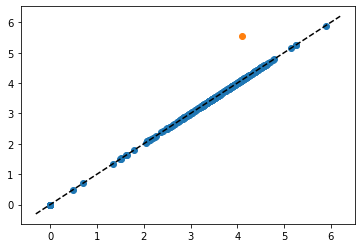

In [887]:
plt.scatter(np.clip(np.log10([counts[x] for x in zip(*np.where(is_mendelian)) if has_variant(x)]), 0, None),
            np.clip(np.log10([real_counts[x] for x in zip(*np.where(is_mendelian)) if has_variant(x)]), 0, None))
plt.scatter(np.clip(np.log10([counts[x] for x in zip(*np.where(is_mendelian)) if not has_variant(x)]), 0, None),
            np.clip(np.log10([real_counts[x] for x in zip(*np.where(is_mendelian)) if not has_variant(x)]), 0, None))
plt.plot(plt.ylim(), plt.ylim(), color='black', linestyle='--')
plt.show()

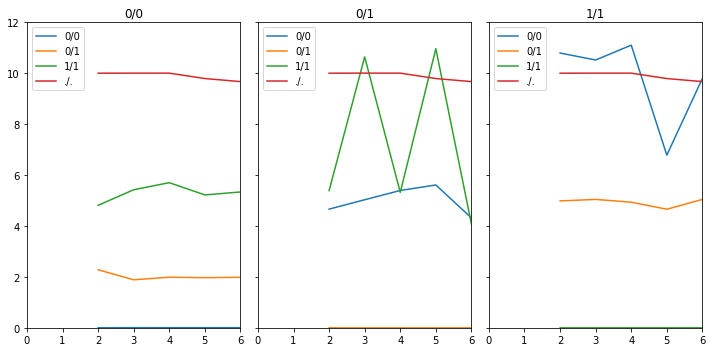

In [888]:
fig, axs = plt.subplots(1, len(gens), sharex=True, sharey=True, figsize=(10, 5))
for i, gen in enumerate(gens):
    axs[i].set_title('%s' % (gen))
    for j, obs in enumerate(obss):
        axs[i].plot(-np.log10(error_rates[:, i, j]), label=obs)
    axs[i].legend()
plt.xlim([0, m-1])
plt.ylim([0, 12])

plt.tight_layout()
plt.show()

In [889]:
with open('../params/platinum_HCR_params.json', 'w+') as f:
    json.dump(params, f, indent=4)